In [33]:
# Load modules

import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import zarr
import gcsfs
from scipy.interpolate import griddata
from xmip.preprocessing import rename_cmip6
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import gridspec
import matplotlib
import cartopy as cart
import statistics

In [2]:
omega_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_wap_37model_piControl_2x2_last250.nc')

land_mask = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_landmask_31model.nc')

tas_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_tas_piControl_2x2_48mod_last250.nc')

ts_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/finalized_var_data/CMIP_ts_39model_piControl_2x2_last250.nc')

In [3]:
models = ['ACCESS-CM2','ACCESS-ESM1-5','AWI-CM-1-1-MR','BCC-CSM2-MR','BCC-ESM1','CAMS-CSM1-0','CanESM5','CESM2',
          'CESM2-FV2','CESM2-WACCM','CESM2-WACCM-FV2','CIESM','CMCC-CM2-SR5','CMCC-ESM2','E3SM-1-0','EC-Earth3',
          'EC-Earth3-AerChem','EC-Earth3-CC','EC-Earth3-Veg-LR','FGOALS-f3-L','FGOALS-g3','GFDL-CM4','GFDL-ESM4',
          'GISS-E2-1-G','INM-CM4-8','INM-CM5-0','IPSL-CM5A2-INCA','MIROC6','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0',
          'NorCPM1','NorESM2-LM','NorESM2-MM','SAM0-UNICON','TaiESM1']

In [4]:
mask = land_mask.mean('name')

In [5]:
omega_cont_mean = omega_cont.isel(time=slice(len(omega_cont.time)-(30*12),
                                             len(omega_cont.time))).sel(lat=slice(-30,30)).mean('time')
omega_cont_trunc = omega_cont_mean.where(mask<50).sel(name=models).mean('name')

In [6]:
tas_cont_rolling = tas_cont.sel(name=models).rolling(time=120, center=True).mean('time')
tas_cont_std = tas_cont_rolling.std('time')
tas_cont_var = tas_cont_std.mean('name').sel(lat=slice(-30,30))

In [8]:
ts_cont_rolling = ts_cont.sel(name=models).rolling(time=120, center=True).mean('time')
ts_cont_std = ts_cont_rolling.std('time')
ts_cont_var = ts_cont_std.mean('name').sel(lat=slice(-30,30))

In [17]:
omega_cont_trunc

<xarray.DataArray 'wap' (lat: 30, lon: 179)>
array([[0.05193118, 0.05307766, 0.0538215 , ..., 0.04038084, 0.04337997,
        0.04637189],
       [0.05073688, 0.05110355, 0.05036222, ..., 0.04300235, 0.0454127 ,
        0.0473379 ],
       [0.04680596, 0.04615902, 0.04422874, ..., 0.04292847, 0.04450458,
        0.04581608],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * lat      (lat) int64 -29 -27 -25 -23 -21 -19 -17 ... 17 19 21 23 25 27 29
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    plev     float64 5e+04
    type     |S4 b'land'

# TAS Bony Decomposition

In [7]:
bin_edges_tas = np.arange(-0.09,0.07,0.005)
print(bin_edges_tas)

[-9.00000000e-02 -8.50000000e-02 -8.00000000e-02 -7.50000000e-02
 -7.00000000e-02 -6.50000000e-02 -6.00000000e-02 -5.50000000e-02
 -5.00000000e-02 -4.50000000e-02 -4.00000000e-02 -3.50000000e-02
 -3.00000000e-02 -2.50000000e-02 -2.00000000e-02 -1.50000000e-02
 -1.00000000e-02 -5.00000000e-03  8.32667268e-17  5.00000000e-03
  1.00000000e-02  1.50000000e-02  2.00000000e-02  2.50000000e-02
  3.00000000e-02  3.50000000e-02  4.00000000e-02  4.50000000e-02
  5.00000000e-02  5.50000000e-02  6.00000000e-02  6.50000000e-02]


In [8]:
omega_cont_mean_ds = omega_cont_mean.mean('name').to_dataset()

In [69]:
omega_cont_mean.mean('name').max()

<xarray.DataArray 'wap' ()>
array(0.06796157)
Coordinates:
    plev     float64 5e+04

In [9]:
omega_cont_mean_ds['tas_var'] = tas_cont_var
omega_cont_mean_ds

<xarray.Dataset>
Dimensions:  (lat: 30, lon: 179)
Coordinates:
    plev     float64 ...
  * lat      (lat) int64 -29 -27 -25 -23 -21 -19 -17 ... 17 19 21 23 25 27 29
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    height   float64 ...
Data variables:
    wap      (lat, lon) float64 0.05193 0.05299 0.05382 ... 0.01641 0.02515
    tas_var  (lat, lon) float64 0.1056 0.1027 0.1004 ... 0.1831 0.1891 0.1974

In [10]:
omega_cont_mean_stack_tas = omega_cont_mean_ds.stack(z=('lat','lon'))

In [11]:
pd.cut(omega_cont_mean_stack_tas['wap'], bins=bin_edges_tas, 
                                               labels=bin_edges_tas[:-1])

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  output = repr(obj)


[0.050, 0.050, 0.050, 0.050, 0.045, ..., 0.025, 0.025, 0.015, 0.015, 0.025]
Length: 5370
Categories (31, float64): [-0.090 < -0.085 < -0.080 < -0.075 ... 0.045 < 0.050 < 0.055 < 0.060]

In [11]:
omega_cont_mean_stack_tas['tags_tas'] = pd.cut(omega_cont_mean_stack_tas['wap'], bins=bin_edges_tas, 
                                               labels=bin_edges_tas[:-1])

In [12]:
omega_cont_mean_stack_tas

<xarray.Dataset>
Dimensions:   (z: 5370, tags_tas: 5370)
Coordinates:
    plev      float64 5e+04
    height    float64 2.0
  * z         (z) object MultiIndex
  * lat       (z) int64 -29 -29 -29 -29 -29 -29 -29 -29 ... 29 29 29 29 29 29 29
  * lon       (z) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * tags_tas  (tags_tas) float64 0.05 0.05 0.05 0.05 ... 0.025 0.015 0.015 0.025
Data variables:
    wap       (z) float64 0.05193 0.05299 0.05382 ... 0.01726 0.01641 0.02515
    tas_var   (z) float64 0.1056 0.1027 0.1004 0.09757 ... 0.1831 0.1891 0.1974

In [51]:
omega_cont_mean_stack_tas.tas_var[0]

<xarray.DataArray 'tas_var' ()>
array(0.10562709)
Coordinates:
    plev     float64 5e+04
    height   float64 2.0
    z        object (-29, 1)
    lat      int64 -29
    lon      int64 1

In [17]:
omega_tas_stats = omega_cont_mean_stack_tas.groupby('tags_tas').groups
omega_tas_stats

{-0.08499999999999999: [2394],
 -0.07999999999999999: [145, 2393],
 -0.07499999999999998: [325, 2215, 2216, 2395],
 -0.06999999999999998: [15,
  504,
  2218,
  2564,
  2572,
  2740,
  3003,
  3182,
  3361,
  3362,
  5234],
 -0.06499999999999997: [1217,
  1873,
  2047,
  2048,
  2049,
  2214,
  2217,
  2391,
  2392,
  2396,
  2554,
  2563,
  2569,
  2570,
  2573,
  2739,
  2743,
  2918,
  2919,
  3004,
  3107,
  3108,
  3109,
  3110,
  3111,
  3112,
  3113,
  3114,
  3115,
  3116,
  3117,
  3118,
  3119,
  3289,
  3290,
  3291,
  3292,
  3293,
  3294,
  3295,
  5057,
  5238],
 -0.05999999999999997: [683,
  684,
  1869,
  1870,
  1871,
  1872,
  1874,
  1875,
  1876,
  1877,
  2039,
  2044,
  2046,
  2050,
  2051,
  2219,
  2375,
  2376,
  2384,
  2385,
  2387,
  2388,
  2397,
  2557,
  2558,
  2559,
  2560,
  2561,
  2562,
  2565,
  2567,
  2568,
  2574,
  2732,
  2738,
  2741,
  2744,
  2748,
  2749,
  2867,
  2913,
  2920,
  2921,
  2922,
  2926,
  2927,
  2928,
  2929,
  3105,
  3106

In [54]:
var_mean_binned = []
for group in omega_tas_stats:
    tas_var_list = []
    for index in omega_tas_stats[group]:
        tas_var_list.append(omega_cont_mean_stack_tas.tas_var[index].item())
    print(statistics.mean(tas_var_list))
    var_mean_binned.append(statistics.mean(tas_var_list))

0.057778109952625195
0.10940417491558188
0.08039173755025597
0.10262499366324206
0.06844612998846164
0.06772999867760099
0.07278794602823398
0.07773489671284005
0.08164484002505472
0.08251951903476215
0.0920050723115162
0.09181092408491597
0.10227646486322885
0.108289326828071
0.11386672207299423
0.11984631545701875
0.12487577694273441
0.1257297535028429
0.1302091603909747
0.13326480718906047
0.13773152320689067
0.1432994287243112
0.14665521618847038
0.14671739087018235
0.1433350924041449
0.137420315196815
0.1401900657956894
0.14393023208393016
0.15211128733021229
0.1609004909255288


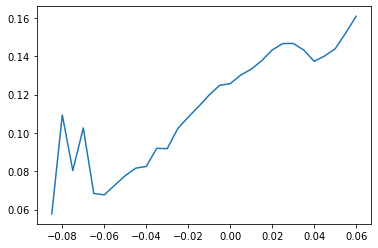

In [57]:
plt.plot(omega_tas_stats.keys(), var_mean_binned)

In [24]:
omega_tas_stats

,count,mean,std,min,25%,50%,75%,max
tags_tas,,,,,,,,
5.000000e-02,128880.0,0.122105,0.040223,0.0561,0.089923,0.117228,0.149062,0.259034
4.500000e-02,300720.0,0.122105,0.040223,0.0561,0.089923,0.117228,0.149062,0.259034
4.000000e-02,386640.0,0.122105,0.040223,0.0561,0.089923,0.117228,0.149062,0.259034
2.500000e-02,1879500.0,0.122105,0.040223,0.0561,0.089923,0.117228,0.149062,0.259034
1.500000e-02,2545380.0,0.122105,0.040223,0.0561,0.089923,0.117228,0.149062,0.259034
2.000000e-02,2803140.0,0.122105,0.040223,0.0561,0.089923,0.117228,0.149062,0.259034
5.000000e-03,2169480.0,0.122105,0.040223,0.0561,0.089923,0.117228,0.149062,0.259034
-1.500000e-02,1761360.0,0.122105,0.040223,0.0561,0.089923,0.117228,0.149062,0.259034
-2.000000e-02,1487490.0,0.122105,0.040223,0.0561,0.089923,0.117228,0.149062,0.259034
